In [2]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from gensim.parsing.preprocessing import remove_stopwords
import tensorflow_hub as hub
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans


import warnings;
warnings.filterwarnings('ignore')

# Loading data

In [2]:
books = pd.read_csv('/media/einhard/Seagate Expansion Drive/3380_data/data/books_dedup.csv').drop('Unnamed: 0', axis=1)
# reviews = pd.read_csv('/media/einhard/Seagate Expansion Drive/3380_data/data/reviews_dedup.csv').drop('Unnamed: 0', axis=1)

In [3]:
reviews = pd.read_csv('/media/einhard/Seagate Expansion Drive/3380_data/data/reviews_EDA.csv').drop('Unnamed: 0', axis=1)

In [5]:
books = books.sort_values('weighted_score', ascending=False).drop_duplicates('title', keep='first').dropna()

In [9]:
books[books.title.isin(['Children of Time'])]

,title,author,average_rating,ratings_count,text_reviews_count,description,shelf_1,book_id,weighted_score,name
16570,Children of Time,1445909.0,4.29,6302.0,852.0,A race for survival among the stars... Humanit...,currently-reading,25499718,4.287046,Adrian Tchaikovsky


In [7]:
reviews = reviews[reviews.book_id.isin(books.book_id)]

In [50]:
books.head(1)

,title,author,average_rating,ratings_count,text_reviews_count,description,shelf_1,book_id,weighted_score,name
208,"A Song of Ice and Fire, 5-Book Boxed Set: A Ga...",346732.0,4.63,10680.0,183.0,"For the first time, all five novels in the epi...",currently-reading,18710619,4.626667,George R.R. Martin


In [51]:
text_cols = ['title', 'description', 'shelf_1','name']
for column in text_cols:
    books[column] = books[column].str.lower()


In [61]:
tmp = 'I like chili sauce to be in my food and I am not too fond of bland food'
remove_stopwords(tmp)

'I like chilli sauce bood I fond bland food'

In [73]:
books = books.reset_index().drop('index', axis=1)

In [7]:
books.sort_values('text_reviews_count', ascending=False)

,title,author,average_rating,ratings_count,text_reviews_count,description,shelf_1,book_id,weighted_score,name
90346,"The Red Pyramid (Kane Chronicles, #1)",15872.0,4.07,239434.0,9981.0,"Since their mother's death, Carter and Sadie h...",currently-reading,7090447,4.069968,Rick Riordan
37651,Carry On,4208569.0,4.19,46984.0,8692.0,Simon Snow is the worst chosen one who's ever ...,ya,23734628,4.189707,Rainbow Rowell
37597,"Bared to You (Crossfire, #1)",19823.0,4.19,222810.0,7793.0,Gideon Cross came into my life like lightning ...,currently-reading,13572249,4.189938,Sylvia Day
32379,The Gentleman's Guide to Vice and Virtue,7327341.0,4.21,12854.0,3568.0,"Henry ""Monty"" Montague was born and bred to be...",currently-reading,29283884,4.208856,Mackenzi Lee
29684,A Mango-Shaped Space,99650.0,4.22,21376.0,2257.0,"Mia Winchell appears to be a typical kid, but ...",favorites,171020,4.219287,Wendy Mass
...,...,...,...,...,...,...,...,...,...,...
353037,The Kayson Cycle,5306110.0,2.73,11.0,1.0,A stranger enters a dying town and makes a des...,kindle,12985718,3.701074,Jonathan D. Allen
324848,Paradise Hops,4350864.0,3.62,49.0,1.0,A brutal attack left Lori Brockton convinced s...,romance,18895677,3.768844,Liz Crowe
232476,Tea Can Wait,7127326.0,3.83,16.0,1.0,Olivia is now in her sixties and widowed.\nShe...,currently-reading,20706896,3.894174,Jacqueline Coote
191031,Astorath The Grim: Redeemer of the Lost,5042757.0,4.00,20.0,1.0,Amongst the brotherhood of the sons of Sanguin...,warhammer-40k,19311667,3.939079,Andy Smillie


In [76]:
tmp = []
for i in range(len(books.description.values.tolist())):
    tmp.append(remove_stopwords(books.description.values.tolist()[i]))

In [87]:
books = pd.merge(books, pd.DataFrame(tmp), left_index=True, right_index=True).rename({0:'descriptionToken'}, axis=1)

# Testing TF USE

In [15]:
import joblib

In [2]:
import pandas as pd
import numpy as np
import random
import tensorflow_hub as hub
import tensorflow as tf

from sklearn.cluster import KMeans

import warnings;
warnings.filterwarnings('ignore')

In [24]:
books = pd.read_csv('/media/einhard/Seagate Expansion Drive/3380_data/data/books_dedup.csv').drop('Unnamed: 0', axis=1)
reviews = pd.read_csv('/media/einhard/Seagate Expansion Drive/3380_data/data/reviews_EDA.csv').drop('Unnamed: 0', axis=1)

In [25]:
books.description.dropna(inplace=True)
books = books[books.text_reviews_count > 300]
reviews.review_text.dropna(inplace=True)
reviews = reviews[reviews.book_id.isin(books.book_id)]
reviews = reviews[(reviews.review_text.str.len() < 90) & (reviews.review_text.str.len() > 30)]
reviews = reviews[~reviews.review_text.str.contains(r'\d\sstar', case=False, regex=True, na=False)]
reviews = reviews[~reviews.review_text.str.contains(r'\d\/\d', case=False, regex=True, na=False)]
reviews = reviews[~reviews.review_text.str.contains(r'\d\.\d', case=False, regex=True, na=False)]
reviews = reviews[~reviews.review_text.str.contains(r'\d\S+\D', case=False, regex=True, na=False)]
reviews = reviews[~reviews.review_text.str.contains(r'http\S+', case=False, regex=True, na=False)]
reviews = reviews[~reviews.review_text.str.contains(r'www\S+', case=False, regex=True, na=False)]


In [110]:
reviews.to_csv('/media/einhard/Seagate Expansion Drive/3380_data/data/filtered_reviews.csv')
books.to_csv('/media/einhard/Seagate Expansion Drive/3380_data/data/filtered_books')


In [6]:
embed = hub.load('/media/einhard/Seagate Expansion Drive/3380_data/tensorflow_hub/universal-sentence-encoder_4')

In [7]:
sentences = reviews.review_text

In [9]:
sentences_vectorized = embed(sentences)

In [18]:
 sentence_array = np.array(sentences_vectorized)

In [19]:
joblib.dump(sentence_array, f'/media/einhard/Seagate Expansion Drive/3380_data/3380-Book-Recommendations/Models/Summarizer/embeddings.pkl')

['/media/einhard/Seagate Expansion Drive/3380_data/3380-Book-Recommendations/Models/Summarizer/embeddings.pkl']

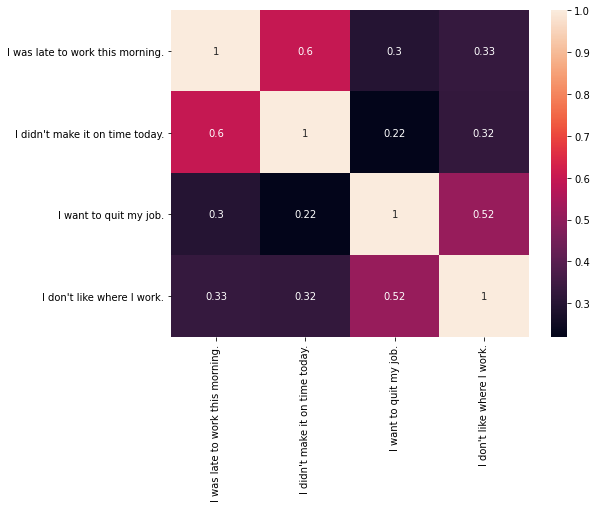

In [38]:
#Create some sample sentences
sample_sentence_a = "I was late to work this morning."
sample_sentence_b = "I didn't make it on time today."
sample_sentence_c = "I want to quit my job."
sample_sentence_d = "I don't like where I work."
sample_sentences = [sample_sentence_a, sample_sentence_b, sample_sentence_c, sample_sentence_d]

# Vectorize sentences
sample_vectors = np.array(embed(sample_sentences))

# Take the inner product of the sentence vectors
sample_ips = np.inner(sample_vectors, sample_vectors)

# Visualize the inner products with a heatmap
plt.figure(figsize=(8,6))
sns.heatmap(sample_ips, annot=True, xticklabels=sample_sentences, yticklabels=sample_sentences)
plt.show()


In [106]:
sample_index = 42
sample_sentence = sentences.iloc[sample_index]

In [123]:
sample_sentence_d = "I've been waiting for a hard sci-fi novel for a long time."
sample_sentences = [sample_sentence_d]
sample_vectors = np.array(embed(sample_sentences))
sample_ips = np.inner(sample_vectors, sentence_array)[0]

# Find the sentences with the highest inner product
top_ten_sents = pd.Series(sample_ips).nlargest(11)
top_ten_indices = top_ten_sents.index.tolist()
top_ten_list = list(reviews.review_text.iloc[top_ten_indices][1:])

print(f'Sample sentence: "{sample_sentence_d}"\n')
print(f'Ten most semantically similar sentences in the dataset:\n\n\n')
print(*top_ten_list, sep='\n\n')

Sample sentence: "I've been waiting for a hard sci-fi novel for a long time."

Ten most semantically similar sentences in the dataset:



This novel got me back into science fiction.

Finally have read a super awesome book! My first sci-fi novel

Probably the best sci-fi novel I've ever read.

Just the best sci fi I've read in a long long time.

One of the best science fiction novels ever.

One of the best science fiction novels ever.

A solidly written hard science fiction novel.

One of the best science fiction books I've ever read.

One of the best science fiction books I've ever read.

This is possibly my favorite sci-fi novel series.


In [125]:
books[books.book_id.isin(reviews.iloc[top_ten_indices].book_id.tolist())][['title', 'name','description', 'weighted_score']]

,title,name,description,weighted_score
5871,The Martian,Andy Weir,"Six days ago, astronaut Mark Watney became one...",4.389945
16072,11/22/63,Stephen King,Life can turn on a dime--or stumble into the e...,4.289929
27208,"Old Man's War (Old Man's War, #1)",John Scalzi,John Perry did two things on his 75th birthday...,4.229844
32053,"Hyperion (Hyperion Cantos, #1)",Dan Simmons,"On the world called Hyperion, beyond the law o...",4.209882
34736,Dune (Dune Chronicles #1),Frank Herbert,This book was mistakenly published under .\nS...,4.199971
63676,"2001: A Space Odyssey (Space Odyssey, #1)",Arthur C. Clarke,"On the Moon, an enigma is uncovered.\nSo great...",4.119941
63682,The Martian Chronicles,Ray Bradbury,The strange and wonderful tale of man's experi...,4.119930
69022,City,Clifford D. Simak,"Simak's ""City"" is a series of connected storie...",4.108845
163953,"Ancillary Justice (Imperial Radch, #1)",Ann Leckie,"On a remote, icy planet, the soldier known as ...",3.969932
172908,The Fountains of Paradise,Arthur C. Clarke,This Hugo and Nebula Award-winning novel is re...,3.959889


In [50]:
# Take a random sentence from our dataset as a sample
sample_index = 15
sample_sentence = sentences.iloc[sample_index]

# Take the inner product of that sentence and all other sentences in our dataset
sample_vector = sentences_vectorized[sample_index]
sample_ips = np.inner(sample_vector, sentence_array)

# Find the sentences with the highest inner product
top_ten_sents = pd.Series(sample_ips).nlargest(11)
top_ten_indices = top_ten_sents.index.tolist()
top_ten_list = list(sentences.iloc[top_ten_indices][1:])

print(f'Sample sentence: "{sample_sentence}"\n')
print(f'Ten most semantically similar sentences in the dataset:\n\n\n')
print(*top_ten_list, sep='\n\n')

Sample sentence: "This book is amazing...... Its so confusing at times but trust me, so worth the read :)"

Ten most semantically similar sentences in the dataset:



I love this book so much! Its worth the read.

This book is amazing. Parts of it were hard to read, but I'm so glad I did.

This book is fantastic. It is a really quick and easy read but is just so good.

I love this book! So much worth the read!

Took me forever to read but it was well worth it. I absolutely loved this book:)

I enjoyed this book immensely! A quick read, but so worth it.

I can't believe I've never read this book. I highly recommend it.

This book is amazing, and it only gets better every time I read it

I really like this book. Really worth the read.

This book is so well written and easy to read. I highly recommend it.


(429626,)

In [49]:
# Take a random sentence from our dataset as a sample
sample_index = 15
sample_sentence = sentences.iloc[sample_index]

# Take the inner product of that sentence and all other sentences in our dataset
sample_vector = sentences_vectorized[sample_index]
sample_ips = np.inner(sample_vector, sentence_array)

# Find the sentences with the highest inner product
top_ten_sents = pd.Series(sample_ips).nlargest(11)
top_ten_indices = top_ten_sents.index.tolist()
top_ten_list = list(sentences.iloc[top_ten_indices][1:])

print(f'Sample sentence: "{sample_sentence}"\n')
print(f'Ten most semantically similar sentences in the dataset:\n\n\n')
print(*top_ten_list, sep='\n\n')

NameError: name 'df' is not defined

In [ ]:
# Set the number of most commonly expressed opinions to identify
k = 8

# Instantiate the model
kmeans_model = KMeans(n_clusters=k, random_state=24)

# Fit the model
kmeans_model.fit(sentences_vectorized);

# Loop through number of clusters
for i in range(k):
    
    # Define cluster centre
    centre = kmeans_model.cluster_centers_[i]
    
    # Calculate inner product of cluster centre and sentence vectors
    ips = np.inner(centre, sentences_vectorized)
    
    # Find the sentence with the highest inner product
    top_index = pd.Series(ips).nlargest(2000).index
    top_sentence = sentences.iloc[top_index]
    
    print(f'Cluster #{i+1} sentence: \n"{top_sentence}"\n')

# Testing funcs

In [3]:
import pandas as pd
import numpy as np

def data_loader(datapath, books_file, reviews_file):
    books = pd.read_csv(datapath + books_file).drop('Unnamed: 0', axis=1)
    reviews = pd.read_csv(datapath + reviews_file).drop('Unnamed: 0', axis=1)
    return books, reviews

In [5]:
import os
import pandas as pd
import numpy as np

import logging
import warnings;
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)
import tensorflow as tf
import tensorflow_hub as hub
import joblib



datapath = '/media/einhard/Seagate Expansion Drive/3380_data/data/Filtered books/'

print('Loading USE...')
embed = hub.load('/media/einhard/Seagate Expansion Drive/3380_data/data/tensorflow_hub/universal-sentence-encoder_4')
print('Success!')

print('Loading word embeddings')
sentence_array = joblib.load('/media/einhard/Seagate Expansion Drive/3380_data/data/Models/reviewEmbeddings.pkl')
descriptions_array = joblib.load('/media/einhard/Seagate Expansion Drive/3380_data/data/Models/descriptionEmbeddings.pkl')
print('Success!')

print('Loading reviews and books')
books, reviews = data_loader(datapath, 'filtered_books.csv', 'filtered_reviews.csv')
print('Success!')

Loading USE...
Success!
Loading word embeddings
Loading reviews and books
Success!


In [9]:
def find_reviews(query,reviews=reviews, n_results=5):
    # Create vector from query and compare with global embedding
    sentence = [query]
    sentence_vector = np.array(embed(sentence))
    inner_product = np.inner(sentence_vector, sentence_array)[0]

    # Find sentences with highest inner products
    top_n_sentences = pd.Series(inner_product).nlargest(n_results+1)
    top_n_indices = top_n_sentences.index.tolist()
    top_n_list = list(reviews.review_text.iloc[top_n_indices][1:])

    print(f'Input sentence: "{query}"\n')
    print(f'{n_results} most semantically similar reviews: \n\n')
    print(*top_n_list, sep='\n\n')
    print(top_n_indices)
    return top_n_indices

def find_books(query, reviews=reviews, books=books):
    top_n_indices = find_reviews(query)
    return books[books.book_id.isin(reviews.iloc[top_n_indices].book_id.tolist())][['title', 'name','description', 'weighted_score']].fillna('')

find_books("I love hard sci fi.") 

Input sentence: "I love hard sci fi."

5 most semantically similar reviews: 


#wickedawesome I love me some epic sci-fi

Very entertaining, thoughful sci fi

I love SciFi but could not get into this

Definitely a great sci fi. I'm not actually into sci-fi but I actually enjoyed this!

Just damn good science fiction.
[248678, 327691, 237485, 210875, 164757, 362901]


,title,name,description,weighted_score
1293,Ready Player One,Ernest Cline,A world at stake.\nA quest for the ultimate pr...,4.309457
1392,"Ender's Game (Ender's Saga, #1)",Orson Scott Card,"Andrew ""Ender"" Wiggin thinks he is playing com...",4.299977
2452,"Old Man's War (Old Man's War, #1)",John Scalzi,John Perry did two things on his 75th birthday...,4.229844
3448,The Dispossessed,Ursula K. Le Guin,"Shevek, a brilliant physicist, decides to take...",4.179725
8521,"Ancillary Justice (Imperial Radch, #1)",Ann Leckie,"On a remote, icy planet, the soldier known as ...",3.969932
9870,"The Iron King (The Iron Fey, #1)",Julie Kagawa,Meghan Chase has a secret destiny; one she cou...,3.919998


In [14]:
reviews.iloc[find_reviews('I love hard sci fi')].sort_values('book_id')

Input sentence: "I love hard sci fi"

5 most semantically similar reviews: 


#wickedawesome I love me some epic sci-fi

Very entertaining, thoughful sci fi

I love SciFi but could not get into this

Definitely a great sci fi. I'm not actually into sci-fi but I actually enjoyed this!

Just damn good science fiction.
[248678, 327691, 237485, 210875, 164757, 362901]


,user_id,book_id,review_id,rating,review_text,date_added,n_votes,n_comments
362901,a0e4473ecf4fba53bed340bb2499bd87,13651,6c222268cfef99d67e316ac9db589426,5,Just damn good science fiction.,Wed Sep 10 19:58:01 -0700 2014,0,0
237485,f53fc27f0fad47f1180df719a0b869ee,51964,3623b4f47aaa1fb05303f1471f184b81,4,"Very entertaining, thoughful sci fi",Mon Nov 24 10:55:14 -0800 2014,0,0
164757,490bdb06ccb5229ae0633e00640c42bd,375802,cd0bae2e0dd092fff4c33c17e2ac2a3e,4,Definitely a great sci fi. I'm not actually in...,Sat Nov 09 12:50:43 -0800 2013,0,0
248678,20cab913f1922f3186982bd75f0f6330,6644117,e14f19e455c2cf9989e7f94b0577fe85,4,i like a little sci fi with my fantasy,Wed Oct 06 19:07:14 -0700 2010,0,0
327691,ed41ce731b99b1ffdd917df0de3578cb,17333324,2088c2d7ee31cb829b872d946e63dde2,3,#wickedawesome I love me some epic sci-fi,Tue Jul 26 14:13:31 -0700 2016,0,0
210875,c7f5b618e1832865e5f3dbed8c838631,20603758,3fdd8565529d6f4d89b0d26471d6446f,1,I love SciFi but could not get into this,Fri Jun 27 09:05:43 -0700 2014,0,0


In [1]:
reviews

NameError: name 'reviews' is not defined

In [21]:
books_and_reviews = pd.merge(reviews, books, on='book_id')[['title', 'name','description','review_text', 'weighted_score','book_id']]

In [22]:
books_and_reviews

,title,name,description,review_text,weighted_score,book_id
0,"Healthy Sleep Habits, Happy Child",Marc Weissbluth,One of the country's leading researchers updat...,Recommended by our pediatrician,3.900093,831635
1,"Healthy Sleep Habits, Happy Child",Marc Weissbluth,One of the country's leading researchers updat...,I wish someone made cliff notes for this book.,3.900093,831635
2,"Healthy Sleep Habits, Happy Child",Marc Weissbluth,One of the country's leading researchers updat...,"Wonderful book, wish I had read it for my firs...",3.900093,831635
3,"Healthy Sleep Habits, Happy Child",Marc Weissbluth,One of the country's leading researchers updat...,This book is designed to make working parents ...,3.900093,831635
4,"Healthy Sleep Habits, Happy Child",Marc Weissbluth,One of the country's leading researchers updat...,I liked Ferber's book a lot better. This was p...,3.900093,831635
...,...,...,...,...,...,...
429621,"Den of Wolves (Blackthorn & Grim, #3)",Juliet Marillier,"The ""powerful and emotionally-charged"" fantasy...",I NEED THIS NOW! *Sulks* \n I want my own Grim...,4.339383,22567184
429622,Nothing Like It in the World: The Men Who Buil...,Stephen E. Ambrose,Nothing Like It in the Worldgives the account ...,would like to return to this someday but wasn'...,3.929907,49255
429623,"Fall From Grace (Blaine Trilogy, #1)",Richard North Patterson,NaN,"Not riveting, more gentle than his usual style...",3.598824,12682653
429624,Scorpions,Walter Dean Myers,"Scorpions, a Newbery Honor Book by National Am...",I listened to this one on CD and really enjoye...,3.812636,229778


In [14]:
books.fillna(value={'description':''}, inplace = True)
del embedDescription
descriptions_vectorized = embed(books.description)

In [16]:
descriptions_array = np.array(descriptions_vectorized)
joblib.dump(descriptions_array, f'/media/einhard/Seagate Expansion Drive/3380_data/data/Models/descriptionEmbeddings.pkl')

['/media/einhard/Seagate Expansion Drive/3380_data/data/Models/descriptionEmbeddings.pkl']

In [34]:
descriptions_array = joblib.load('/media/einhard/Seagate Expansion Drive/3380_data/data/Models/descriptionEmbeddings.pkl')


In [46]:
def find_description(query, books=books, n_results=10):
    # Create vector from query and compare with global embedding
    sentence = [query]
    sentence_vector = np.array(embed(sentence))
    inner_product = np.inner(sentence_vector, descriptions_array)[0]

    # Find sentences with highest inner products
    top_n_sentences = pd.Series(inner_product).nlargest(n_results+1)
    top_n_indices = top_n_sentences.index.tolist()
    top_n_list = list(books.description.iloc[top_n_indices][1:])

    print(f'Input sentence: "{query}"\n')
    print(f'{n_results} most semantically similar book descriptions: \n\n')
    print(*top_n_list, sep='\n\n')
    return top_n_indices

def find_books_description(query, reviews=reviews, books=books):
    top_n_indices = find_description(query)
    return books[books.book_id.isin(books.iloc[top_n_indices].book_id.tolist())][['title', 'name','description', 'weighted_score']].fillna('')

find_books_description('Humans and robots')


Input sentence: "Humans and robots"

10 most semantically similar book descriptions: 


What are the jobs of the future? How many will there be? And who will have them? We might imagine--and hope--that today's industrial revolution will unfold like the last: even as some jobs are eliminated, more will be created to deal with the new innovations of a new era. In Rise of the Robots, Silicon Valley entrepreneur Martin Ford argues that this is absolutely not the case. As technology continues to accelerate and machines begin taking care of themselves, fewer people will be necessary. Artificial intelligence is already well on its way to making "good jobs" obsolete: many paralegals, journalists, office workers, and even computer programmers are poised to be replaced by robots and smart software. As progress continues, blue and white collar jobs alike will evaporate, squeezing working- and middle-class families ever further. At the same time, households are under assault from exploding costs, 

,title,name,description,weighted_score
3627,"I, Robot (Robot #0.1)",Isaac Asimov,The three laws of Robotics:\n1) A robot may no...,4.169937
4004,"Adulthood Rites (Xenogenesis, #2)",Octavia E. Butler,"In this sequel to Dawn, Lilith Iyapo has given...",4.158280
4341,The Caves of Steel (Robot #1),Isaac Asimov,A millennium into the future two advancements ...,4.139784
4839,The Naked Sun (Robot #2),Isaac Asimov,"A millennium into the future, two advancements...",4.119622
6764,Little Robot,Ben Hatke,Life outside the robot factory is confusing.\n...,4.047513
7034,Rise of the Robots: Technology and the Threat ...,Martin Ford,What are the jobs of the future? How many will...,4.038102
7265,"Trigger (Origin, #1)",Scarlett Dawn,"New York Times bestselling author, Scarlett Da...",4.028555
8348,Physics of the Future: How Science Will Shape ...,Michio Kaku,"Imagine, if you can, the world in the year 210...",3.979689
8695,"The Second Machine Age: Work, Progress, and Pr...",Erik Brynjolfsson,"A revolution is under way. In recent years, Go...",3.969141
8982,The Automatic Detective,A. Lee Martinez,"Even in Empire City, a town where weird scienc...",3.959325


# K-means optimization

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import tensorflow_hub as hub

plt.rcParams['figure.figsize']=(8.0, 6.0)
%config InlineBackend.figure_format='retina'

In [2]:
def get_scores(sentence_vectors, k_min=2, k_max=10):
    '''
    Function to calculate a k-means model's inertia and silhouette scores for a range of k values
    '''

    # Set range of k values to loop through
    ks = range(k_min, k_max + 1)

    # Initialize lists to store inertia scores and silhouette scores
    inertia_scores = []
    sil_scores = []

    # Loop through values of k
    for k in ks:

        # Instantiate the model
        kmeans_model = KMeans(n_clusters=k, random_state=24)

        # Fit the model
        kmeans_model.fit(sentence_array)

        # Append the model's inertia score to master list
        inertia_scores.append(kmeans_model.inertia_)

        # Append the model's silhouette score to master list
        labels = kmeans_model.labels_
        sil_score = silhouette_score(sentence_vectors, labels)
        sil_scores.append(sil_score)
        
    return inertia_scores, sil_scores, ks

In [1]:
def load_sentences(df):
    '''
    Function to load and embed a book's sentences
    '''
    # Copy sentence column to new variable
    sentences = df['review_text']

    # Vectorize sentences
    sentence_vectors = embed(sentences)
    
    return sentences, sentence_vectors

In [115]:
books[books.text_reviews_count < 1000].sort_values('text_reviews_count', ascending=False)

,title,author,average_rating,ratings_count,text_reviews_count,description,shelf_1,book_id,weighted_score,name
85564,"Bittersweet (True North, #1)",7737308.0,4.08,4614.0,731.0,The new series is set in Vermont. True North i...,currently-reading,28161530,4.078228,Sarina Bowen
173713,"Hunter (Hunter, #1)",8685.0,3.96,3079.0,662.0,They came after the Diseray. Some were terrors...,fantasy,24397041,3.959276,Mercedes Lackey
227286,"SYLO (The SYLO Chronicles, #1)",74046.0,3.90,3681.0,600.0,Does Tucker Pierce have what it takes to be a ...,NaN,16101054,3.900197,D.J. MacHale
227400,"The Agreement (Unrestrained, #1)",6426012.0,3.90,6923.0,574.0,Journalism graduate student Kate McDermott is ...,currently-reading,17699906,3.900106,S.E. Lund
181454,Tourist Season,8178.0,3.95,14026.0,558.0,A bizarre series of killings in Florida lead a...,fiction,13064,3.949875,Carl Hiaasen
...,...,...,...,...,...,...,...,...,...,...
170393,Insects!,7123817.0,4.15,13.0,1.0,This book has over 45+ Awesome photos of Insec...,NaN,18105553,3.963262,Cyndy Adamsen
243452,The World According to Vice.,4384051.0,3.75,12.0,1.0,"Since it was founded in Montreal in 1994, VICE...",owned,9411328,3.882831,Vice
79635,The First Folio of Shakespeare,16258590.0,4.71,14.0,1.0,NaN,NaN,2240310,4.088680,Peter W. M. Blayney
144480,Gamma,5019087.0,4.36,11.0,1.0,Multiplication for single and multiple-digit n...,currently-reading,11983332,3.995008,Steve Demme


In [119]:
reviews[reviews.book_id == 24397041].review_text

85015      The people who DNFed this in the first 20-25% ...
111178     It took me about 5 chapters to really get into...
125371     DNF at 25% \n I love the cover! It's so beauti...
193133     To be honest, I don't remember Mercedes Lackey...
207167     In a future United States where magical creatu...
                                 ...                        
8723198    It was okay. \n I listed to the audiobook. It ...
8775962    2.5/5. Although I enjoyed the idea of this sto...
8824702    I feel like so many of the futuristic books ar...
8940873    I was disappointed by this book. I read the ba...
8955578    This is one of those books when I am wishing f...
Name: review_text, Length: 218, dtype: object

In [21]:
CoT_sentences, CoT_sentence_vectors = load_sentences(reviews[reviews.book_id == 25499718])

In [22]:
inertia_scores, sil_scores, ks = get_scores(CoT_sentence_vectors)

NameError: name 'KMeans' is not defined

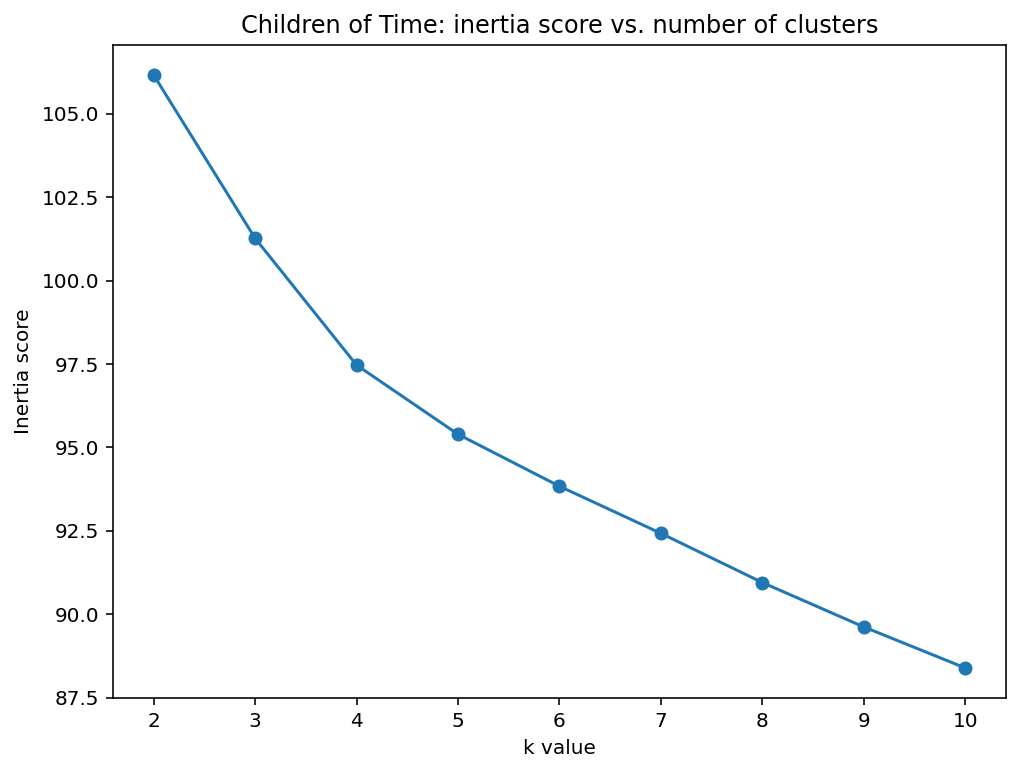

In [145]:
plt.figure()
plt.plot(ks, inertia_scores, marker='o')
plt.xlabel('k value')
plt.ylabel('Inertia score')
plt.title('Children of Time: inertia score vs. number of clusters')
plt.show()

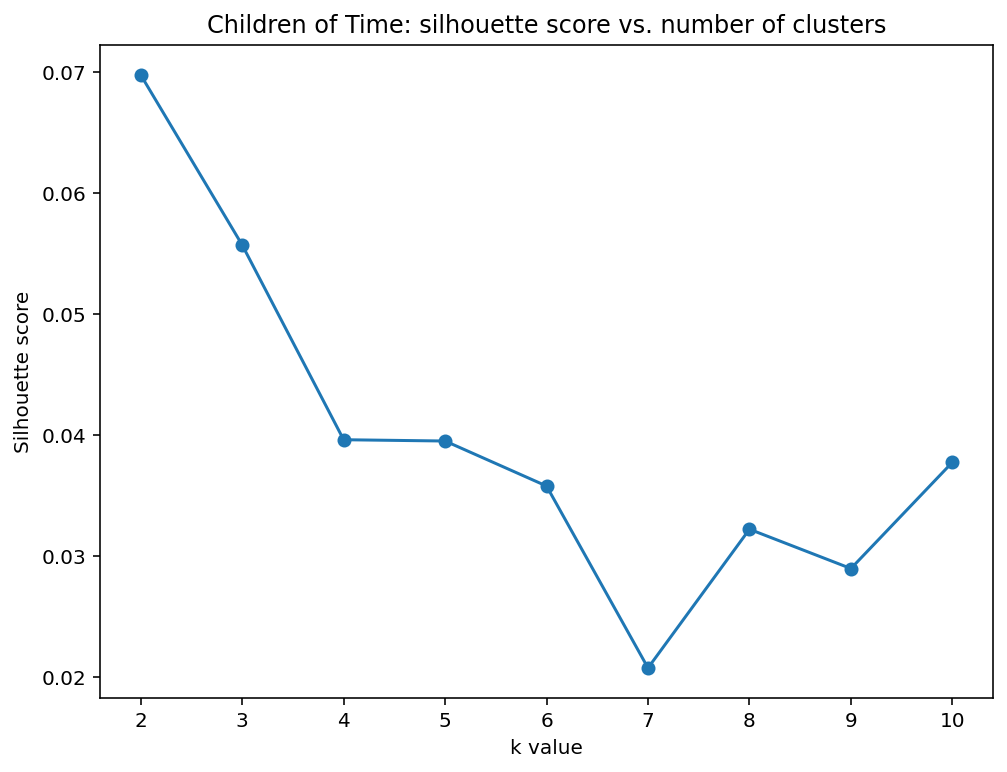

In [146]:
plt.figure()
plt.plot(ks, sil_scores, marker='o')
plt.xlabel('k value')
plt.ylabel('Silhouette score')
plt.title('Children of Time: silhouette score vs. number of clusters')
plt.show()

In [23]:
def get_clusters(sentences, sentence_vectors, k, n):
    '''
    Function to extract the n most representative sentences from k clusters
    '''

    # Instantiate the model
    kmeans_model = KMeans(n_clusters=k, random_state=24)

    # Fit the model
    kmeans_model.fit(sentence_array)
    
    # Loop through number of clusters
    for i in range(k):

        # Define cluster centre
        centre = kmeans_model.cluster_centers_[i]

        # Calculate inner product of cluster centre and sentence vectors
        ips = np.inner(centre, sentence_vectors)

        # Find the sentences with the highest inner products
        top_indices = pd.Series(ips).nlargest(n).index
        top_sentences = list(sentences.iloc[top_indices])

        print(f'Cluster #{i+1} sentences:\n')
        print(*top_sentences, sep='\n\n')
        print('\n')

In [27]:
get_clusters(CoT_sentences, CoT_sentence_vectors, k=8, n=8)

Cluster #1 sentences:

Excellent! Can't wait to read more books by this author!!

A very unique and well written story.

Really liked this one. Great world building

A great story, a very quick read

Very enjoyable book. Unexpected ending. Setting the stage for more.

Good read, reminded me of Vernor Vinge and his Zones of thought series.

Brilliant! I wish there were sequels!

Excellent novel, interesting concepts that make you think.


Cluster #2 sentences:

Excellent! Can't wait to read more books by this author!!

Good read, reminded me of Vernor Vinge and his Zones of thought series.

Really liked this one. Great world building

A great story, a very quick read

Very enjoyable book. Unexpected ending. Setting the stage for more.

Excellent novel, interesting concepts that make you think.

A very unique and well written story.

Brilliant! I wish there were sequels!


Cluster #3 sentences:

Pretty much blew my mind and got me thinking about everything I thought I knew...

Brilliant!

In [161]:
atlwcs_sentences, atlwcs_sentence_vectors = load_sentences(reviews[reviews.book_id == 18143977])

In [162]:
inertia_scores, sil_scores, ks = get_scores(atlwcs_sentence_vectors)

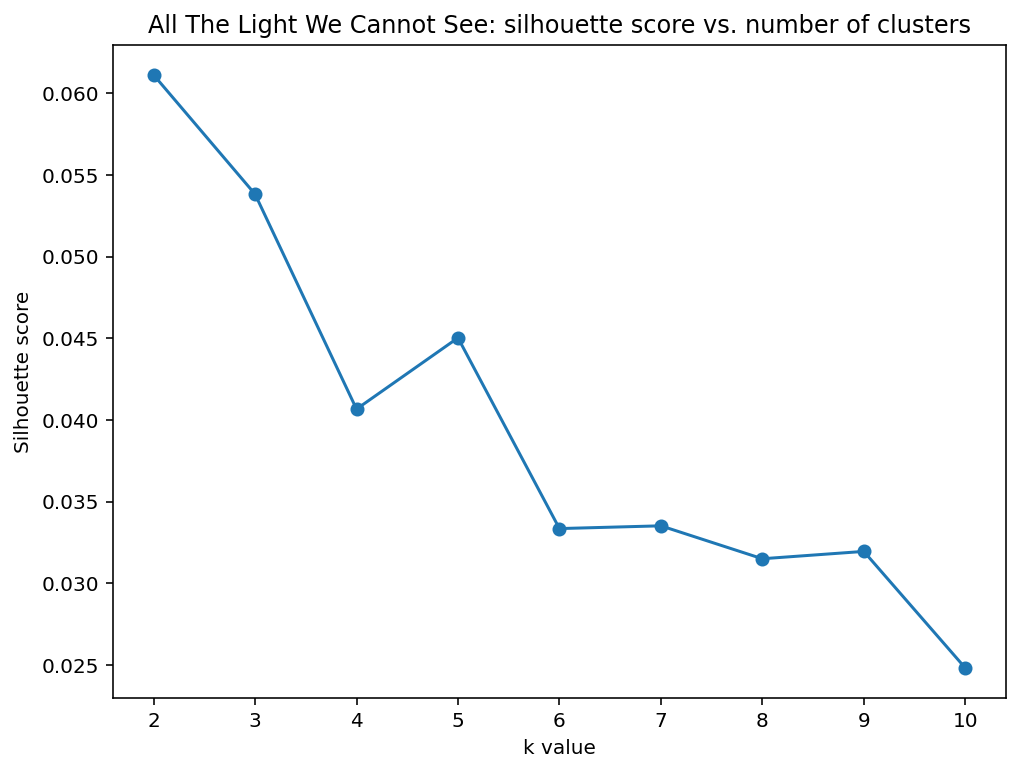

In [163]:
plt.figure()
plt.plot(ks, sil_scores, marker='o')
plt.xlabel('k value')
plt.ylabel('Silhouette score')
plt.title('All The Light We Cannot See: silhouette score vs. number of clusters')
plt.show()

In [26]:
get_clusters(atlwcs_sentences, atlwcs_sentence_vectors, k=5, n=8)

NameError: name 'atlwcs_sentences' is not defined

In [165]:
get_clusters(atlwcs_sentences, atlwcs_sentence_vectors, k=9, n=8)

Cluster #1 sentences:

As I sit at my computer, my fingers on the keys, I am stumped. The words won't come. I feel inadequate to the task of reviewing this book. 
 All the Light We Cannot See is the best book I read this year, the kind of life-changing read you come across maybe once every five years, a book that involves you and transforms you, arresting time, an instant classic. 
 In the years leading up to World War 2, Marie-Laure LeBlanc grows up blind, but beloved, in Paris, where her devoted father teaches her that, just because she is blind, it doesn't mean that she has to be helpless. Werner Pfennig grows up a penniless orphan in a grim German mining town, doomed to spend his life in the same mines that killed his father, until the Nazis notice he has a gift with radio circuits. 
 And then history takes over. Werner is sent to a brutal Nazi finishing school, where he learns, in equal measures, trigonometry and how to suppress his troubled conscience. As the Nazis invade Paris, 

## KMeans should be done with clusters between k=2 and k=10, depending